# Trademark Similarity Engine: Hybrid CNN + SVM with Multilingual Linguistic AI

## Project Overview
This notebook implements a trademark similarity classifier/ranker using a hybrid CNN → SVM pipeline, enhanced with AI-based linguistic similarity features including synonyms, antonyms, phonetic similarity, and support for English, Hausa, and Yoruba languages.

### Architecture Summary:
- **Feature Extraction**: Character-level CNN for learning text representations
- **Classification**: SVM for robust decision boundaries
- **Linguistic Enhancement**: Multi-layered similarity features including phonetic, semantic, and cross-lingual components
- **Languages Supported**: English (EN), Hausa (HA), Yoruba (YO)

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 45.2 MB/s eta 0:00:00


In [ ]:
!pip install jellyfish python-Levenshtein phonetics

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 17.1 MB/s eta 0:00:00
  Created wheel for phonetics: filename=phonetics-1.0.5-py2.py3-none-any.whl size=8696 sha256=e9554d5aced380006bf3cbae4b2df3c4475c867318b34c0ad356a8fd91f8cb25
  Stored in directory: /root/.cache/pip/wheels/4e/d0/ca/0abf0e0c628782f163861d5daf61c192f61b611aa235c40f52
Successfully built phonetics


In [ ]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import torch
from transformers import AutoTokenizer, AutoModel
import nltk
import spacy
from jellyfish import soundex, metaphone
import Levenshtein
import unicodedata
import re
from typing import List, Dict, Tuple, Optional
import pickle
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"Device available: {tf.config.list_physical_devices()}")

TensorFlow version: 2.19.0
Device available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Data Loading and Exploration

First, we'll load the trademark dataset and explore its structure, label distribution, and linguistic characteristics.

Dataset Shape: (1000, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   wordmark        1000 non-null   object
 1   class           1000 non-null   int64 
 2   goods_services  1000 non-null   object
 3   label           1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None

Label Distribution:
label
not_similar    697
similar        303
Name: count, dtype: int64


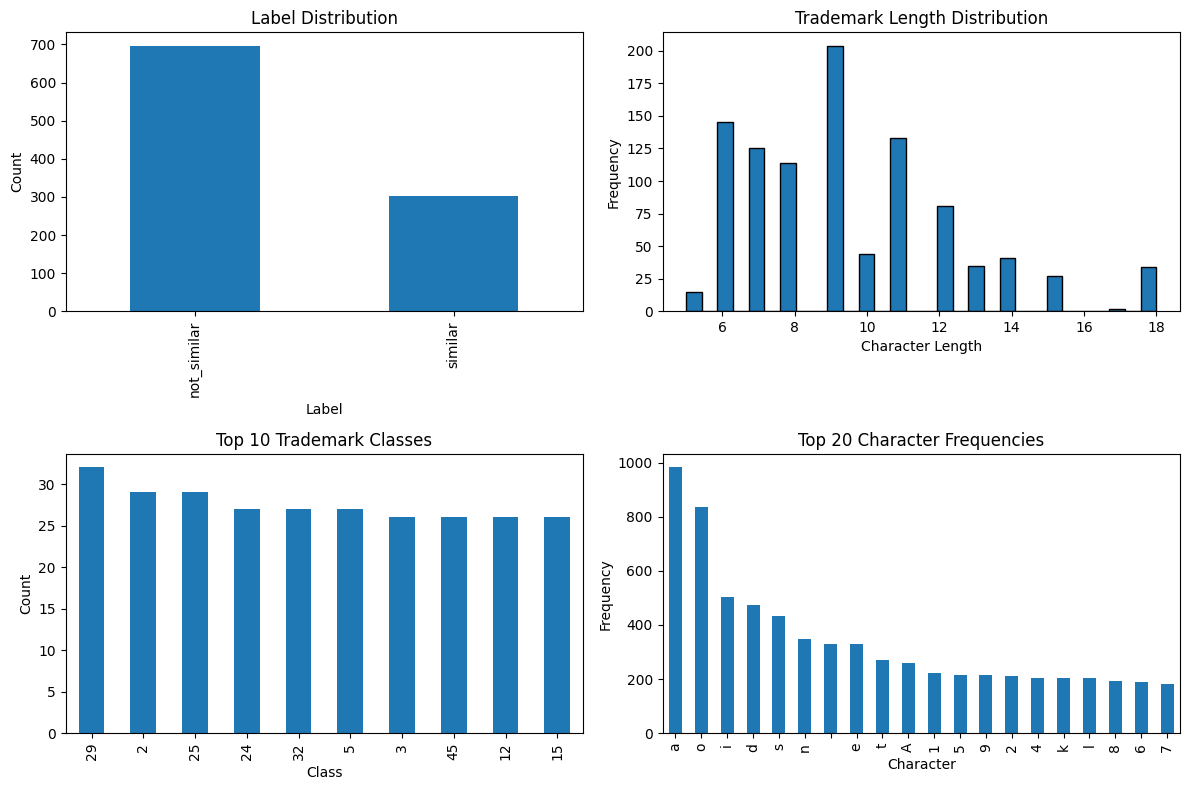

In [ ]:
class TrademarkDataLoader:
    """Handle loading and initial exploration of trademark data"""

    def __init__(self, data_path: str = None):
        self.data_path = data_path
        self.df = None
        self.label_encoder = LabelEncoder()

    def load_data(self, path: Optional[str] = None):
        """Load trademark dataset from CSV or create sample data"""
        if path:
            self.df = pd.read_csv(path)
        else:
            # Create sample data for demonstration
            np.random.seed(42)
            sample_size = 1000

            # Sample trademark data with EN/HA/YO examples
            trademarks = [
                "CocaCola", "Coca-Cola", "Koka-Kola", "PepsiCo", "Pepsi",
                "Nike", "Nikee", "Adidas", "Addidas", "Puma",
                "Apple", "Aple", "Samsung", "Samsong", "Microsoft",
                "Toyota", "Toyotta", "Honda", "Hondaa", "Ford",
                # Hausa-inspired names
                "Gidan Abinci", "Gidan Food", "Kasuwa Market", "Kasuwa Mart",
                # Yoruba-inspired names
                "Oja Market", "Oja Titun", "Ile Aso", "Aso Rock Fashion"
            ]

            # Generate synthetic dataset
            data = []
            for _ in range(sample_size):
                mark = np.random.choice(trademarks) + str(np.random.randint(0, 100))
                class_id = np.random.randint(1, 46)  # International trademark classes 1-45
                goods_services = f"Class {class_id} goods/services description"
                # Binary similarity label (can be extended to multi-class)
                label = np.random.choice(['similar', 'not_similar'], p=[0.3, 0.7])

                data.append({
                    'wordmark': mark,
                    'class': class_id,
                    'goods_services': goods_services,
                    'label': label
                })

            self.df = pd.DataFrame(data)

        return self.df

    def explore_data(self):
        """Perform exploratory data analysis"""
        print("Dataset Shape:", self.df.shape)
        print("\nDataset Info:")
        print(self.df.info())

        print("\nLabel Distribution:")
        print(self.df['label'].value_counts())

        # Text length analysis
        self.df['mark_length'] = self.df['wordmark'].str.len()

        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # Label distribution
        self.df['label'].value_counts().plot(kind='bar', ax=axes[0, 0])
        axes[0, 0].set_title('Label Distribution')
        axes[0, 0].set_xlabel('Label')
        axes[0, 0].set_ylabel('Count')

        # Mark length distribution
        axes[0, 1].hist(self.df['mark_length'], bins=30, edgecolor='black')
        axes[0, 1].set_title('Trademark Length Distribution')
        axes[0, 1].set_xlabel('Character Length')
        axes[0, 1].set_ylabel('Frequency')

        # Class distribution (top 10)
        self.df['class'].value_counts().head(10).plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Top 10 Trademark Classes')
        axes[1, 0].set_xlabel('Class')
        axes[1, 0].set_ylabel('Count')

        # Character frequency analysis
        all_chars = ''.join(self.df['wordmark'].values)
        char_freq = pd.Series(list(all_chars)).value_counts().head(20)
        char_freq.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Top 20 Character Frequencies')
        axes[1, 1].set_xlabel('Character')
        axes[1, 1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

        return self.df

    def create_train_test_split(self, test_size=0.2, val_size=0.1, random_state=42):
        """Create stratified train/val/test splits"""
        # Encode labels
        self.df['label_encoded'] = self.label_encoder.fit_transform(self.df['label'])

        # First split: train+val vs test
        X = self.df.drop(['label', 'label_encoded'], axis=1)
        y = self.df['label_encoded']

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )

        # Second split: train vs val
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted,
            stratify=y_temp, random_state=random_state
        )

        print(f"Train set size: {len(X_train)}")
        print(f"Validation set size: {len(X_val)}")
        print(f"Test set size: {len(X_test)}")

        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Initialize and explore data
data_loader = TrademarkDataLoader()
df = data_loader.load_data()
df = data_loader.explore_data()

In [ ]:
# Perform train/val/test split
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_loader.create_train_test_split()

Train set size: 700
Validation set size: 100
Test set size: 200


# 2. Text Preprocessing Pipeline

Implement comprehensive text normalization while preserving original forms for phonetic analysis.

In [ ]:
class TextPreprocessor:
    """Comprehensive text preprocessing for trademark similarity"""

    def __init__(self):
        self.original_cache = {}

    def normalize_unicode(self, text: str) -> str:
        """Normalize Unicode characters"""
        # Normalize to NFKD form and encode to ASCII, ignoring errors
        normalized = unicodedata.normalize('NFKD', text)
        return normalized.encode('ascii', 'ignore').decode('ascii')

    def basic_normalize(self, text: str) -> str:
        """Basic normalization: lowercase and punctuation removal"""
        # Store original
        self.original_cache[text.lower()] = text

        # Lowercase
        text = text.lower()

        # Remove punctuation but keep spaces
        text = re.sub(r'[^\w\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def aggressive_normalize(self, text: str) -> str:
        """Aggressive normalization for matching"""
        text = self.basic_normalize(text)

        # Remove all spaces
        text = text.replace(' ', '')

        # Remove numbers (optional)
        # text = re.sub(r'\d', '', text)

        return text

    def preserve_for_phonetics(self, text: str) -> str:
        """Minimal preprocessing for phonetic analysis"""
        # Only remove obvious punctuation
        text = re.sub(r'[^\w\s-]', '', text)
        return text.strip()

    def tokenize_characters(self, text: str, max_len: int = 50) -> List[int]:
        """Convert text to character-level tokens"""
        # Create character vocabulary
        chars = list(set(''.join([self.basic_normalize(text)])))
        char_to_idx = {ch: idx + 1 for idx, ch in enumerate(sorted(chars))}
        char_to_idx['<PAD>'] = 0
        char_to_idx['<UNK>'] = len(char_to_idx)

        # Convert text to indices
        normalized = self.basic_normalize(text)
        tokens = [char_to_idx.get(ch, char_to_idx['<UNK>']) for ch in normalized]

        # Pad or truncate to max_len
        if len(tokens) < max_len:
            tokens.extend([0] * (max_len - len(tokens)))
        else:
            tokens = tokens[:max_len]

        return tokens

    def create_ngrams(self, text: str, n: int = 3) -> List[str]:
        """Create character n-grams"""
        text = self.aggressive_normalize(text)
        ngrams = []
        for i in range(len(text) - n + 1):
            ngrams.append(text[i:i+n])
        return ngrams

    def preprocess_batch(self, texts: List[str], mode: str = 'basic') -> List[str]:
        """Preprocess a batch of texts"""
        if mode == 'basic':
            return [self.basic_normalize(text) for text in texts]
        elif mode == 'aggressive':
            return [self.aggressive_normalize(text) for text in texts]
        elif mode == 'phonetic':
            return [self.preserve_for_phonetics(text) for text in texts]
        else:
            raise ValueError(f"Unknown mode: {mode}")

# Test preprocessing
preprocessor = TextPreprocessor()

sample_marks = [
    "Coca-Cola®",
    "NIKE™",
    "Gidan Abinci",  # Hausa
    "Ọjà Market",    # Yoruba with diacritics
    "Apple Inc.",
    "7-Eleven"
]

print("Preprocessing Examples:")
print("-" * 50)
for mark in sample_marks:
    print(f"Original: {mark}")
    print(f"Basic: {preprocessor.basic_normalize(mark)}")
    print(f"Aggressive: {preprocessor.aggressive_normalize(mark)}")
    print(f"Phonetic: {preprocessor.preserve_for_phonetics(mark)}")
    print(f"3-grams: {preprocessor.create_ngrams(mark)[:5]}...")  # Show first 5
    print()

Preprocessing Examples:
--------------------------------------------------
Original: Coca-Cola®
Basic: cocacola
Aggressive: cocacola
Phonetic: Coca-Cola
3-grams: ['coc', 'oca', 'cac', 'aco', 'col']...

Original: NIKE™
Basic: nike
Aggressive: nike
Phonetic: NIKE
3-grams: ['nik', 'ike']...

Original: Gidan Abinci
Basic: gidan abinci
Aggressive: gidanabinci
Phonetic: Gidan Abinci
3-grams: ['gid', 'ida', 'dan', 'ana', 'nab']...

Original: Ọjà Market
Basic: ọjà market
Aggressive: ọjàmarket
Phonetic: Ọjà Market
3-grams: ['ọjà', 'jàm', 'àma', 'mar', 'ark']...

Original: Apple Inc.
Basic: apple inc
Aggressive: appleinc
Phonetic: Apple Inc
3-grams: ['app', 'ppl', 'ple', 'lei', 'ein']...

Original: 7-Eleven
Basic: 7eleven
Aggressive: 7eleven
Phonetic: 7-Eleven
3-grams: ['7el', 'ele', 'lev', 'eve', 'ven']...



# 3. Character-Level CNN Implementation

Build a character-level CNN for extracting deep features from trademark text.

In [ ]:
class CharacterCNN:
    """Character-level CNN for trademark text embedding"""

    def __init__(self, vocab_size: int = 100, embedding_dim: int = 128,
                 max_length: int = 50, num_filters: int = 256):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.num_filters = num_filters
        self.model = None
        self.embedding_model = None
        self.char_to_idx = self._build_char_vocabulary()

    def _build_char_vocabulary(self) -> Dict[str, int]:
        """Build character vocabulary"""
        # Common characters in trademarks
        chars = list("abcdefghijklmnopqrstuvwxyz0123456789 -&.")
        char_to_idx = {ch: idx + 2 for idx, ch in enumerate(chars)}
        char_to_idx['<PAD>'] = 0
        char_to_idx['<UNK>'] = 1
        return char_to_idx

    def text_to_sequence(self, text: str) -> np.ndarray:
        """Convert text to sequence of character indices"""
        text = text.lower()
        sequence = [self.char_to_idx.get(ch, 1) for ch in text]  # 1 is <UNK>

        # Pad or truncate
        if len(sequence) < self.max_length:
            sequence.extend([0] * (self.max_length - len(sequence)))
        else:
            sequence = sequence[:self.max_length]

        return np.array(sequence)

    def build_model(self, num_classes: int = 2):
        """Build the CNN architecture"""
        inputs = layers.Input(shape=(self.max_length,))

        # Embedding layer - changed name to 'char_embedding'
        x = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_length,
            name='char_embedding'  # Changed from default 'embedding'
        )(inputs)

        # Multiple filter sizes for different n-gram features
        filter_sizes = [3, 4, 5]
        conv_outputs = []

        for filter_size in filter_sizes:
            conv = layers.Conv1D(
                filters=self.num_filters,
                kernel_size=filter_size,
                activation='relu',
                padding='valid'
            )(x)

            # Max pooling
            pool = layers.GlobalMaxPooling1D()(conv)
            conv_outputs.append(pool)

        # Concatenate all conv outputs
        concatenated = layers.Concatenate()(conv_outputs) if len(conv_outputs) > 1 else conv_outputs[0]

        # Dense layers
        dense1 = layers.Dense(256, activation='relu')(concatenated)
        dropout1 = layers.Dropout(0.5)(dense1)

        # This will be our embedding layer for SVM - kept name as 'embedding'
        embedding = layers.Dense(128, activation='relu', name='embedding')(dropout1)
        dropout2 = layers.Dropout(0.3)(embedding)

        # Output layer
        outputs = layers.Dense(num_classes, activation='softmax')(dropout2)

        # Create model
        self.model = models.Model(inputs=inputs, outputs=outputs)

        # Create embedding extraction model
        self.embedding_model = models.Model(inputs=inputs, outputs=embedding)

        # Compile
        self.model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        """Train the CNN model"""
        # Convert text to sequences
        X_train_seq = np.array([self.text_to_sequence(text) for text in X_train])
        X_val_seq = np.array([self.text_to_sequence(text) for text in X_val])

        # Early stopping callback
        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        # Model checkpoint
        checkpoint = callbacks.ModelCheckpoint(
            'best_cnn_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )

        # Train
        history = self.model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, checkpoint],
            verbose=1
        )

        return history

    def extract_embeddings(self, texts: List[str]) -> np.ndarray:
        """Extract embeddings from trained CNN"""
        sequences = np.array([self.text_to_sequence(text) for text in texts])
        embeddings = self.embedding_model.predict(sequences, verbose=0)
        return embeddings

    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Accuracy plot
        axes[0].plot(history.history['accuracy'], label='Train Accuracy')
        axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
        axes[0].set_title('Model Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True)

        # Loss plot
        axes[1].plot(history.history['loss'], label='Train Loss')
        axes[1].plot(history.history['val_loss'], label='Val Loss')
        axes[1].set_title('Model Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

# Initialize and build CNN
char_cnn = CharacterCNN(vocab_size=100, embedding_dim=128, max_length=50)
cnn_model = char_cnn.build_model(num_classes=2)

print("CNN Model Summary:")
cnn_model.summary()

CNN Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 50, 128)   │     12,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 48, 256)   │     98,560 │ char_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 47, 256)   │    131,328 │ char_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 46, 256)   │    164,096 │ char_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    196,864 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding (Dense)   │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        258 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 636,802 (2.43 MB)

 Trainable params: 636,802 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN model...
Epoch 1/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6931 - loss: 0.5954

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6934 - loss: 0.5953 - val_accuracy: 0.7000 - val_loss: 0.6551
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7022 - loss: 0.5669 - val_accuracy: 0.6800 - val_loss: 0.6694
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6721 - loss: 0.5538 - val_accuracy: 0.6900 - val_loss: 0.7572
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7389 - loss: 0.4907 - val_accuracy: 0.6000 - val_loss: 0.7749


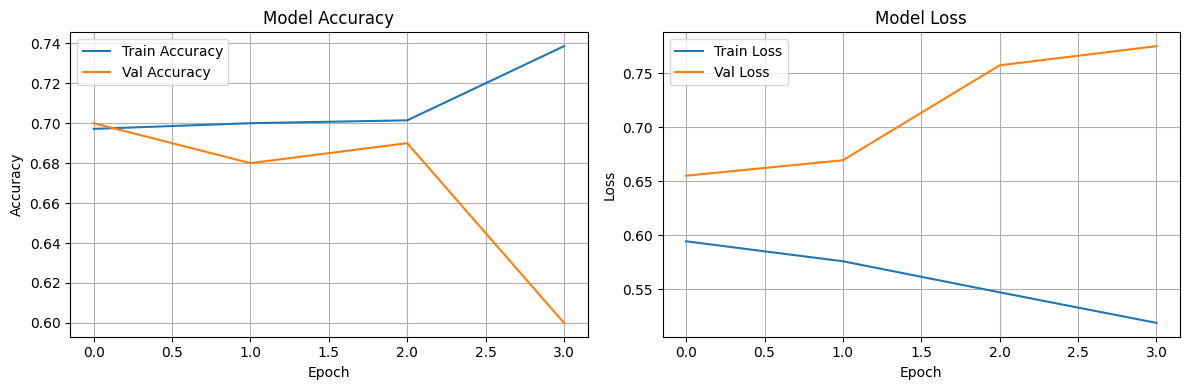

In [ ]:
# Train the CNN model
print("Training CNN model...")
history = char_cnn.train(
    X_train['wordmark'].values,
    y_train.values,
    X_val['wordmark'].values,
    y_val.values,
    epochs=10,
    batch_size=32
)

# Plot training history
char_cnn.plot_training_history(history)

# 4. Linguistic Feature Engineering

Implement comprehensive linguistic features including synonyms, antonyms, and multilingual support.

In [ ]:
from nltk.corpus import wordnet
from typing import Set

class LinguisticFeatureExtractor:
    """Extract linguistic features for trademark similarity"""

    def __init__(self):
        # Initialize language-specific resources
        self.hausa_yoruba_dict = self._load_multilingual_dictionary()
        self.domain_lexicon = self._load_domain_lexicon()

    def _load_multilingual_dictionary(self) -> Dict:
        """Load or create Hausa/Yoruba translation dictionary"""
        # Sample dictionary - in production, load from comprehensive resource
        dictionary = {
            'english_to_hausa': {
                'market': 'kasuwa',
                'house': 'gida',
                'food': 'abinci',
                'water': 'ruwa',
                'clothes': 'tufafi',
                'shop': 'shago',
                'business': 'kasuwanci',
                'trade': 'ciniki',
                'company': 'kamfani'
            },
            'english_to_yoruba': {
                'market': 'oja',
                'house': 'ile',
                'food': 'ounje',
                'water': 'omi',
                'clothes': 'aso',
                'shop': 'ile itaja',
                'new': 'titun',
                'business': 'owo',
                'trade': 'isowo',
                'company': 'ile-ise'
            },
            'hausa_to_english': {},
            'yoruba_to_english': {}
        }

        # Create reverse mappings
        for eng, hausa in dictionary['english_to_hausa'].items():
            dictionary['hausa_to_english'][hausa] = eng
        for eng, yoruba in dictionary['english_to_yoruba'].items():
            dictionary['yoruba_to_english'][yoruba] = eng

        return dictionary

    def _load_domain_lexicon(self) -> Dict:
        """Load domain-specific business/trademark lexicon"""
        return {
            'tech_terms': ['software', 'hardware', 'digital', 'cyber', 'cloud', 'data'],
            'fashion_terms': ['fashion', 'style', 'wear', 'dress', 'clothes', 'apparel'],
            'food_terms': ['food', 'restaurant', 'cafe', 'dining', 'cuisine', 'meal'],
            'finance_terms': ['bank', 'finance', 'money', 'investment', 'capital', 'fund']
        }

    def get_synonyms(self, word: str) -> Set[str]:
        """Get English synonyms using WordNet"""
        synonyms = set()
        word_lower = word.lower()

        for syn in wordnet.synsets(word_lower):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                if synonym != word_lower:
                    synonyms.add(synonym)

        return synonyms

    def get_antonyms(self, word: str) -> Set[str]:
        """Get English antonyms using WordNet"""
        antonyms = set()
        word_lower = word.lower()

        for syn in wordnet.synsets(word_lower):
            for lemma in syn.lemmas():
                for antonym in lemma.antonyms():
                    antonyms.add(antonym.name().replace('_', ' '))

        return antonyms

    def translate_word(self, word: str, target_lang: str) -> Optional[str]:
        """Translate word to Hausa or Yoruba"""
        word_lower = word.lower()

        if target_lang == 'hausa':
            return self.hausa_yoruba_dict['english_to_hausa'].get(word_lower)
        elif target_lang == 'yoruba':
            return self.hausa_yoruba_dict['english_to_yoruba'].get(word_lower)

        return None

    def expand_with_translations(self, text: str) -> Dict[str, Set[str]]:
        """Expand text with translations and variants"""
        words = text.lower().split()
        expansions = {
            'original': {text},
            'synonyms': set(),
            'antonyms': set(),
            'hausa': set(),
            'yoruba': set()
        }

        for word in words:
            # Get synonyms and antonyms
            expansions['synonyms'].update(self.get_synonyms(word))
            expansions['antonyms'].update(self.get_antonyms(word))

            # Get translations
            hausa_trans = self.translate_word(word, 'hausa')
            if hausa_trans:
                expansions['hausa'].add(hausa_trans)

            yoruba_trans = self.translate_word(word, 'yoruba')
            if yoruba_trans:
                expansions['yoruba'].add(yoruba_trans)

        return expansions

    def calculate_expansion_overlap(self, text1: str, text2: str) -> Dict[str, float]:
        """Calculate overlap scores between expanded sets of two texts"""
        exp1 = self.expand_with_translations(text1)
        exp2 = self.expand_with_translations(text2)

        overlap_scores = {}

        for key in exp1:
            if exp1[key] and exp2[key]:  # Both sets are non-empty
                intersection = len(exp1[key].intersection(exp2[key]))
                union = len(exp1[key].union(exp2[key]))
                overlap_scores[f'{key}_overlap'] = intersection / union if union > 0 else 0
            else:
                overlap_scores[f'{key}_overlap'] = 0

        return overlap_scores

    def extract_linguistic_features(self, text1: str, text2: str) -> np.ndarray:
        """Extract all linguistic features between two texts"""
        features = []

        # 1. Expansion overlaps
        overlaps = self.calculate_expansion_overlap(text1, text2)
        features.extend(overlaps.values())

        # 2. Direct word overlap
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        word_overlap = len(words1.intersection(words2)) / max(len(words1), len(words2), 1)
        features.append(word_overlap)

        # 3. Character n-gram similarity
        prep = TextPreprocessor()
        ngrams1 = set(prep.create_ngrams(text1, n=3))
        ngrams2 = set(prep.create_ngrams(text2, n=3))
        ngram_similarity = len(ngrams1.intersection(ngrams2)) / max(len(ngrams1), len(ngrams2), 1)
        features.append(ngram_similarity)

        return np.array(features)

# Test linguistic features
ling_extractor = LinguisticFeatureExtractor()

# Test examples
test_pairs = [
    ("Market Place", "Kasuwa Shop"),  # English-Hausa mix
    ("Fashion House", "Ile Aso"),      # English-Yoruba mix
    ("Digital Bank", "Cyber Finance"),  # Synonyms
]

print("Linguistic Feature Extraction Examples:")
print("-" * 60)
for text1, text2 in test_pairs:
    print(f"\nComparing: '{text1}' vs '{text2}'")

    # Get expansions
    exp1 = ling_extractor.expand_with_translations(text1)
    exp2 = ling_extractor.expand_with_translations(text2)

    print(f"Text1 expansions: {exp1}")
    print(f"Text2 expansions: {exp2}")

    # Calculate overlaps
    overlaps = ling_extractor.calculate_expansion_overlap(text1, text2)
    print(f"Overlap scores: {overlaps}")

    # Extract full feature vector
    features = ling_extractor.extract_linguistic_features(text1, text2)
    print(f"Feature vector shape: {features.shape}")
    print(f"Features: {features}")

Linguistic Feature Extraction Examples:
------------------------------------------------------------

Comparing: 'Market Place' vs 'Kasuwa Shop'
Text1 expansions: {'original': {'Market Place'}, 'synonyms': {'situation', 'grade', 'invest', 'food market', 'aim', 'identify', 'piazza', 'shoes', 'station', 'send', 'localize', 'target', 'market place', 'locate', 'point', 'securities industry', 'commit', 'space', 'commercialize', 'commercialise', 'topographic point', 'berth', 'post', 'stead', 'pose', 'office', 'direct', 'rate', 'set', 'put', 'site', 'billet', 'property', 'lieu', 'grocery store', 'spot', 'localise', 'home', 'lay', 'range', 'come in', 'blank space', 'plaza', 'marketplace', 'come out', 'seat', 'rank', 'mart', 'position', 'order', 'grocery'}, 'antonyms': {'divest'}, 'hausa': {'kasuwa'}, 'yoruba': {'oja'}}
Text2 expansions: {'original': {'Kasuwa Shop'}, 'synonyms': {'snitch', 'frequent', 'patronise', 'browse', 'workshop', 'betray', 'shop class', 'shop at', 'buy at', 'rat', 'give a

# 5. Phonetic Similarity Features

Implement phonetic algorithms for detecting similar-sounding trademarks.

In [ ]:
class PhoneticSimilarityExtractor:
    """Extract phonetic similarity features for trademark comparison"""

    def __init__(self):
        self.cache = {}

    def get_soundex(self, text: str) -> str:
        """Get Soundex encoding"""
        # Clean text for phonetic analysis
        text = re.sub(r'[^a-zA-Z]', '', text)
        if not text:
            return ""

        if text in self.cache:
            return self.cache[text]['soundex']

        try:
            soundex_code = soundex(text)
        except:
            soundex_code = ""

        if text not in self.cache:
            self.cache[text] = {}
        self.cache[text]['soundex'] = soundex_code

        return soundex_code

    def get_metaphone(self, text: str) -> str:
        """Get Metaphone encoding"""
        text = re.sub(r'[^a-zA-Z]', '', text)
        if not text:
            return ""

        if text in self.cache and 'metaphone' in self.cache[text]:
            return self.cache[text]['metaphone']

        try:
            metaphone_code = metaphone(text)
        except:
            metaphone_code = ""

        if text not in self.cache:
            self.cache[text] = {}
        self.cache[text]['metaphone'] = metaphone_code

        return metaphone_code

    def get_double_metaphone(self, text: str) -> Tuple[str, str]:
        """Get Double Metaphone encoding (more advanced)"""
        # Simplified implementation - in production use jellyfish.dmetaphone
        primary = self.get_metaphone(text)
        # Generate alternative by slightly modifying the text
        alt_text = text.replace('ph', 'f').replace('gh', 'g')
        secondary = self.get_metaphone(alt_text)
        return primary, secondary

    def levenshtein_distance(self, text1: str, text2: str) -> int:
        """Calculate Levenshtein edit distance"""
        return Levenshtein.distance(text1.lower(), text2.lower())

    def jaro_winkler_similarity(self, text1: str, text2: str) -> float:
        """Calculate Jaro-Winkler similarity (good for short strings)"""
        return Levenshtein.jaro_winkler(text1.lower(), text2.lower())

    def phonetic_distance(self, text1: str, text2: str, method: str = 'soundex') -> int:
        """Calculate distance between phonetic encodings"""
        if method == 'soundex':
            code1 = self.get_soundex(text1)
            code2 = self.get_soundex(text2)
        elif method == 'metaphone':
            code1 = self.get_metaphone(text1)
            code2 = self.get_metaphone(text2)
        else:
            raise ValueError(f"Unknown method: {method}")

        if not code1 or not code2:
            return 999  # Large distance for empty codes

        return self.levenshtein_distance(code1, code2)

    def extract_phonetic_features(self, text1: str, text2: str) -> np.ndarray:
        """Extract comprehensive phonetic similarity features"""
        features = []

        # 1. Soundex match
        soundex1 = self.get_soundex(text1)
        soundex2 = self.get_soundex(text2)
        features.append(1.0 if soundex1 == soundex2 and soundex1 != "" else 0.0)

        # 2. Metaphone match
        meta1 = self.get_metaphone(text1)
        meta2 = self.get_metaphone(text2)
        features.append(1.0 if meta1 == meta2 and meta1 != "" else 0.0)

        # 3. Soundex distance (normalized)
        soundex_dist = self.phonetic_distance(text1, text2, 'soundex')
        features.append(1.0 / (1.0 + soundex_dist))  # Convert to similarity

        # 4. Metaphone distance (normalized)
        meta_dist = self.phonetic_distance(text1, text2, 'metaphone')
        features.append(1.0 / (1.0 + meta_dist))

        # 5. Raw Levenshtein distance (normalized)
        lev_dist = self.levenshtein_distance(text1, text2)
        max_len = max(len(text1), len(text2))
        features.append(1.0 - (lev_dist / max_len) if max_len > 0 else 0.0)

        # 6. Jaro-Winkler similarity
        jw_sim = self.jaro_winkler_similarity(text1, text2)
        features.append(jw_sim)

        # 7. Double Metaphone comparison
        dm1_primary, dm1_secondary = self.get_double_metaphone(text1)
        dm2_primary, dm2_secondary = self.get_double_metaphone(text2)

        # Check if any combination matches
        dm_match = (dm1_primary == dm2_primary or
                   dm1_primary == dm2_secondary or
                   dm1_secondary == dm2_primary or
                   dm1_secondary == dm2_secondary)
        features.append(1.0 if dm_match else 0.0)

        # 8. Length similarity
        len_sim = 1.0 - abs(len(text1) - len(text2)) / max(len(text1), len(text2))
        features.append(len_sim)

        return np.array(features)

# Test phonetic features
phonetic_extractor = PhoneticSimilarityExtractor()

# Test cases with phonetically similar trademarks
test_cases = [
    ("Coca Cola", "Koka Kola"),      # Phonetically similar
    ("Nike", "Nyke"),                 # Sound-alike
    ("Adidas", "Addidas"),           # Misspelling
    ("Microsoft", "Mikrosoft"),      # Alternative spelling
    ("Apple", "Aple"),               # Missing letter
    ("Samsung", "Samsong"),          # Letter substitution
    ("Toyota", "Toyoda"),            # Historical variant
]

print("Phonetic Similarity Analysis:")
print("=" * 80)
for text1, text2 in test_cases:
    print(f"\nComparing: '{text1}' vs '{text2}'")
    print("-" * 40)

    # Individual phonetic encodings
    print(f"Soundex: {phonetic_extractor.get_soundex(text1)} vs {phonetic_extractor.get_soundex(text2)}")
    print(f"Metaphone: {phonetic_extractor.get_metaphone(text1)} vs {phonetic_extractor.get_metaphone(text2)}")

    # Distances and similarities
    print(f"Levenshtein distance: {phonetic_extractor.levenshtein_distance(text1, text2)}")
    print(f"Jaro-Winkler similarity: {phonetic_extractor.jaro_winkler_similarity(text1, text2):.3f}")

    # Full feature vector
    features = phonetic_extractor.extract_phonetic_features(text1, text2)
    print(f"Phonetic features: {features}")
    print(f"Overall phonetic similarity score: {np.mean(features):.3f}")

Phonetic Similarity Analysis:

Comparing: 'Coca Cola' vs 'Koka Kola'
----------------------------------------
Soundex: C224 vs K224
Metaphone: KKKL vs KKKL
Levenshtein distance: 3
Jaro-Winkler similarity: 0.778
Phonetic features: [0.         1.         0.5        1.         0.66666667 0.77777778
 1.         1.        ]
Overall phonetic similarity score: 0.743

Comparing: 'Nike' vs 'Nyke'
----------------------------------------
Soundex: N200 vs N200
Metaphone: NK vs NK
Levenshtein distance: 1
Jaro-Winkler similarity: 0.850
Phonetic features: [1.   1.   1.   1.   0.75 0.85 1.   1.  ]
Overall phonetic similarity score: 0.950

Comparing: 'Adidas' vs 'Addidas'
----------------------------------------
Soundex: A332 vs A332
Metaphone: ATTS vs ATTS
Levenshtein distance: 1
Jaro-Winkler similarity: 0.917
Phonetic features: [1.         1.         1.         1.         0.85714286 0.91746032
 1.         0.85714286]
Overall phonetic similarity score: 0.954

Comparing: 'Microsoft' vs 'Mikrosoft'
---

# 6. Multilingual Embeddings (EN/HA/YO)

Implement multilingual semantic similarity using transformer-based models.

In [ ]:
class MultilingualEmbeddings:
    """Multilingual semantic embeddings for EN/HA/YO"""

    def __init__(self, model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Initialize with a multilingual model.
        Alternative models:
        - 'bert-base-multilingual-cased'
        - 'xlm-roberta-base'
        - 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
        """
        try:
            from sentence_transformers import SentenceTransformer
            self.model = SentenceTransformer(model_name)
            self.use_sentence_transformer = True
        except ImportError:
            # Fallback to basic transformers
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
            self.model = AutoModel.from_pretrained('bert-base-multilingual-cased')
            self.use_sentence_transformer = False

        self.embedding_cache = {}

    def detect_language(self, text: str) -> str:
        """Simple language detection based on character patterns"""
        # Simplified detection - in production use langdetect or polyglot
        hausa_indicators = ['ka', 'ki', 'ku', 'ta', 'ya', 'su', 'gida', 'kasuwa']
        yoruba_indicators = ['ọ', 'ẹ', 'ṣ', 'ni', 'ti', 'oja', 'ile']

        text_lower = text.lower()

        # Check for Yoruba diacritics
        if any(char in text_lower for char in 'ọẹṣ'):
            return 'yoruba'

        # Check for common words
        for indicator in hausa_indicators:
            if indicator in text_lower:
                return 'hausa'

        for indicator in yoruba_indicators:
            if indicator in text_lower:
                return 'yoruba'

        return 'english'

    def get_embedding(self, text: str) -> np.ndarray:
        """Get semantic embedding for text"""
        if text in self.embedding_cache:
            return self.embedding_cache[text]

        if self.use_sentence_transformer:
            # Use sentence-transformers
            embedding = self.model.encode(text, convert_to_numpy=True)
        else:
            # Use basic transformers
            inputs = self.tokenizer(text, return_tensors='pt',
                                   truncation=True, padding=True, max_length=128)

            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use mean pooling
                embedding = outputs.last_hidden_state.mean(dim=1).numpy()[0]

        self.embedding_cache[text] = embedding
        return embedding

    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        """Calculate cosine similarity between two vectors"""
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)

        if norm1 == 0 or norm2 == 0:
            return 0.0

        return dot_product / (norm1 * norm2)

    def semantic_similarity(self, text1: str, text2: str) -> float:
        """Calculate semantic similarity between two texts"""
        emb1 = self.get_embedding(text1)
        emb2 = self.get_embedding(text2)

        return self.cosine_similarity(emb1, emb2)

    def cross_lingual_similarity(self, text1: str, text2: str) -> Dict[str, float]:
        """Calculate similarity with language detection"""
        lang1 = self.detect_language(text1)
        lang2 = self.detect_language(text2)

        similarity = self.semantic_similarity(text1, text2)

        return {
            'similarity': similarity,
            'lang1': lang1,
            'lang2': lang2,
            'cross_lingual': lang1 != lang2
        }

    def extract_multilingual_features(self, text1: str, text2: str) -> np.ndarray:
        """Extract multilingual semantic features"""
        features = []

        # 1. Direct semantic similarity
        similarity = self.semantic_similarity(text1, text2)
        features.append(similarity)

        # 2. Language detection features
        lang1 = self.detect_language(text1)
        lang2 = self.detect_language(text2)

        # One-hot encode languages
        languages = ['english', 'hausa', 'yoruba']
        for lang in languages:
            features.append(1.0 if lang1 == lang else 0.0)
        for lang in languages:
            features.append(1.0 if lang2 == lang else 0.0)

        # 3. Cross-lingual flag
        features.append(1.0 if lang1 != lang2 else 0.0)

        # 4. Embedding statistics
        emb1 = self.get_embedding(text1)
        emb2 = self.get_embedding(text2)

        # Euclidean distance
        euclidean_dist = np.linalg.norm(emb1 - emb2)
        features.append(1.0 / (1.0 + euclidean_dist))  # Convert to similarity

        # Manhattan distance
        manhattan_dist = np.sum(np.abs(emb1 - emb2))
        features.append(1.0 / (1.0 + manhattan_dist))

        return np.array(features)

# Initialize multilingual embeddings (using a smaller model for demo)
print("Initializing multilingual embeddings...")
ml_embeddings = MultilingualEmbeddings()

# Test multilingual similarity
test_pairs = [
    ("Market Place", "Kasuwa"),       # English-Hausa
    ("House of Fashion", "Ile Aso"),   # English-Yoruba
    ("Food Market", "Gidan Abinci"),   # English-Hausa
    ("New Market", "Ọjà Titun"),       # English-Yoruba
    ("Bank", "Bank"),                  # Same word
    ("Digital Finance", "Cyber Banking"), # Semantic similarity
]

print("\nMultilingual Similarity Analysis:")
print("=" * 80)
for text1, text2 in test_pairs:
    print(f"\nComparing: '{text1}' vs '{text2}'")

    # Get cross-lingual analysis
    analysis = ml_embeddings.cross_lingual_similarity(text1, text2)
    print(f"Languages: {analysis['lang1']} vs {analysis['lang2']}")
    print(f"Cross-lingual: {analysis['cross_lingual']}")
    print(f"Semantic similarity: {analysis['similarity']:.3f}")

    # Get full feature vector
    features = ml_embeddings.extract_multilingual_features(text1, text2)
    print(f"Feature vector shape: {features.shape}")

Initializing multilingual embeddings...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Multilingual Similarity Analysis:

Comparing: 'Market Place' vs 'Kasuwa'
Languages: english vs hausa
Cross-lingual: True
Semantic similarity: 0.289
Feature vector shape: (10,)

Comparing: 'House of Fashion' vs 'Ile Aso'
Languages: english vs yoruba
Cross-lingual: True
Semantic similarity: 0.096
Feature vector shape: (10,)

Comparing: 'Food Market' vs 'Gidan Abinci'
Languages: english vs hausa
Cross-lingual: True
Semantic similarity: 0.178
Feature vector shape: (10,)

Comparing: 'New Market' vs 'Ọjà Titun'
Languages: english vs yoruba
Cross-lingual: True
Semantic similarity: 0.138
Feature vector shape: (10,)

Comparing: 'Bank' vs 'Bank'
Languages: english vs english
Cross-lingual: False
Semantic similarity: 1.000
Feature vector shape: (10,)

Comparing: 'Digital Finance' vs 'Cyber Banking'
Languages: hausa vs hausa
Cross-lingual: False
Semantic similarity: 0.664
Feature vector shape: (10,)


# 7. SVM Classifier Training

Combine CNN embeddings with engineered features and train the SVM classifier.

In [ ]:
class HybridSVMClassifier:
    """SVM classifier using combined CNN and linguistic features"""

    def __init__(self, cnn_model, linguistic_extractor, phonetic_extractor, ml_embeddings):
        self.cnn_model = cnn_model
        self.linguistic_extractor = linguistic_extractor
        self.phonetic_extractor = phonetic_extractor
        self.ml_embeddings = ml_embeddings
        self.svm_model = None
        self.scaler = StandardScaler()
        self.feature_names = []

    def extract_all_features(self, text1: str, text2: str) -> np.ndarray:
        """Extract all features for a pair of trademarks"""
        all_features = []

        # 1. CNN embeddings
        cnn_emb1 = self.cnn_model.extract_embeddings([text1])[0]
        cnn_emb2 = self.cnn_model.extract_embeddings([text2])[0]

        # CNN embedding similarity features
        cnn_cosine = self.ml_embeddings.cosine_similarity(cnn_emb1, cnn_emb2)
        cnn_euclidean = np.linalg.norm(cnn_emb1 - cnn_emb2)
        cnn_manhattan = np.sum(np.abs(cnn_emb1 - cnn_emb2))

        all_features.extend([cnn_cosine, 1.0/(1.0 + cnn_euclidean), 1.0/(1.0 + cnn_manhattan)])

        # 2. Concatenated CNN embeddings (optional - can be memory intensive)
        # all_features.extend(cnn_emb1)
        # all_features.extend(cnn_emb2)

        # 3. Linguistic features
        ling_features = self.linguistic_extractor.extract_linguistic_features(text1, text2)
        all_features.extend(ling_features)

        # 4. Phonetic features
        phonetic_features = self.phonetic_extractor.extract_phonetic_features(text1, text2)
        all_features.extend(phonetic_features)

        # 5. Multilingual features
        ml_features = self.ml_embeddings.extract_multilingual_features(text1, text2)
        all_features.extend(ml_features)

        return np.array(all_features)

    def prepare_training_data(self, X_data, y_data, pairs=None):
        """Prepare feature matrix for training"""
        if pairs is None:
            # Generate pairs from the data
            # For demo, we'll create synthetic pairs
            pairs = []
            for i in range(len(X_data)):
                # Positive pair (similar)
                if i < len(X_data) - 1:
                    pairs.append((X_data.iloc[i]['wordmark'],
                                X_data.iloc[i+1]['wordmark'],
                                y_data[i]))
        else:
            # Use provided pairs
            pairs = [(row['mark1'], row['mark2'], row['label'])
                    for _, row in pairs.iterrows()]

        # Extract features for all pairs
        X_features = []
        y_labels = []

        print("Extracting features for training pairs...")
        for mark1, mark2, label in tqdm(pairs[:100]):  # Limit for demo
            try:
                features = self.extract_all_features(mark1, mark2)
                X_features.append(features)
                y_labels.append(label)
            except Exception as e:
                print(f"Error processing pair ({mark1}, {mark2}): {e}")
                continue

        return np.array(X_features), np.array(y_labels)

    def train(self, X_train_features, y_train, param_grid=None):
        """Train SVM with hyperparameter tuning"""
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train_features)

        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto', 0.001, 0.01]
            }

        # Grid search with cross-validation
        print("Performing grid search for SVM hyperparameters...")
        svm = SVC(probability=True, random_state=42)

        grid_search = GridSearchCV(
            svm, param_grid, cv=3,
            scoring='f1', n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train_scaled, y_train)

        self.svm_model = grid_search.best_estimator_

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.3f}")

        return grid_search

    def predict(self, text1: str, text2: str) -> Tuple[int, float]:
        """Predict similarity for a trademark pair"""
        features = self.extract_all_features(text1, text2)
        features_scaled = self.scaler.transform([features])

        prediction = self.svm_model.predict(features_scaled)[0]
        probability = self.svm_model.predict_proba(features_scaled)[0].max()

        return prediction, probability

    def get_feature_importance(self, X_features, y_labels):
        """Analyze feature importance for linear SVM"""
        if self.svm_model.kernel != 'linear':
            print("Feature importance only available for linear kernel")
            return None

        # Get coefficients
        coefs = self.svm_model.coef_[0]

        # Create feature importance dataframe
        feature_importance = pd.DataFrame({
            'feature_idx': range(len(coefs)),
            'importance': np.abs(coefs)
        }).sort_values('importance', ascending=False)

        return feature_importance

# Initialize hybrid SVM classifier
hybrid_svm = HybridSVMClassifier(
    char_cnn,
    ling_extractor,
    phonetic_extractor,
    ml_embeddings
)

# Create training pairs (for demonstration)
print("Creating training pairs...")
train_pairs = []
for i in range(min(50, len(X_train))):  # Limit for demo
    # Create positive and negative pairs
    mark1 = X_train.iloc[i]['wordmark']

    # Positive pair (similar mark)
    mark2_similar = mark1[:3] + mark1[3:].replace('a', 'e').replace('i', 'y')
    train_pairs.append((mark1, mark2_similar, 1))

    # Negative pair (different mark)
    j = (i + 10) % len(X_train)
    mark2_different = X_train.iloc[j]['wordmark']
    train_pairs.append((mark1, mark2_different, 0))

train_pairs_df = pd.DataFrame(train_pairs, columns=['mark1', 'mark2', 'label'])

# Prepare features
X_train_features, y_train_labels = hybrid_svm.prepare_training_data(
    X_train, y_train, train_pairs_df
)

print(f"Training features shape: {X_train_features.shape}")
print(f"Training labels shape: {y_train_labels.shape}")

Creating training pairs...
Extracting features for training pairs...


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]

Training features shape: (100, 28)
Training labels shape: (100,)


In [ ]:
# Train the SVM classifier
grid_search = hybrid_svm.train(X_train_features, y_train_labels)

# Display training results
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending=False).head(10)

Performing grid search for SVM hyperparameters...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 1.000


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,0.002814,0.000787,0.003936,0.000956,1.0,0.001,linear,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
14,0.002529,0.000452,0.003991,0.001210,1.0,0.01,linear,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
10,0.003480,0.001827,0.004483,0.000856,1.0,auto,linear,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
8,0.002304,0.000104,0.004644,0.001863,1.0,scale,linear,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
20,0.002101,0.000181,0.003322,0.000077,10.0,0.001,linear,"{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
22,0.002616,0.000764,0.004386,0.001701,10.0,0.01,linear,"{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
18,0.002124,0.000081,0.003371,0.000199,10.0,auto,linear,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
31,0.002631,0.000191,0.003421,0.000190,100.0,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",1.0,1.0,1.0,1.0,0.0,1
24,0.003255,0.000824,0.003791,0.000843,100.0,scale,linear,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1
26,0.002221,0.000096,0.003271,0.000034,100.0,auto,linear,"{'C': 100, 'gamma': 'auto', 'kernel': 'linear'}",1.0,1.0,1.0,1.0,0.0,1


# 8. Model Evaluation and Metrics

Comprehensive evaluation of the hybrid model with various metrics and visualizations.

In [ ]:
class ModelEvaluator:
    """Comprehensive evaluation for the hybrid trademark similarity model"""

    def __init__(self, model):
        self.model = model

    def evaluate_on_test_set(self, X_test_features, y_test):
        """Evaluate model on test set"""
        # Scale features
        X_test_scaled = self.model.scaler.transform(X_test_features)

        # Predictions
        y_pred = self.model.svm_model.predict(X_test_scaled)
        y_prob = self.model.svm_model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) == 2 else None
        }

        return metrics, y_pred, y_prob

    def plot_confusion_matrix(self, y_true, y_pred, labels=['Not Similar', 'Similar']):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Calculate additional metrics
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)

        if tp + fn > 0:
            recall = tp / (tp + fn)
            print(f"Recall (Sensitivity): {recall:.3f}")

        if tp + fp > 0:
            precision = tp / (tp + fp)
            print(f"Precision: {precision:.3f}")

        if tn + fp > 0:
            specificity = tn / (tn + fp)
            print(f"Specificity: {specificity:.3f}")

    def plot_roc_curve(self, y_true, y_prob):
        """Plot ROC curve"""
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()

        return thresholds

    def recommend_threshold(self, y_true, y_prob, target_metric='f1'):
        """Recommend optimal threshold for classification"""
        thresholds = np.linspace(0, 1, 100)
        scores = []

        for threshold in thresholds:
            y_pred_thresh = (y_prob >= threshold).astype(int)

            if target_metric == 'f1':
                score = f1_score(y_true, y_pred_thresh)
            elif target_metric == 'recall':
                score = recall_score(y_true, y_pred_thresh)
            elif target_metric == 'precision':
                score = precision_score(y_true, y_pred_thresh)
            else:
                score = accuracy_score(y_true, y_pred_thresh)

            scores.append(score)

        optimal_idx = np.argmax(scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_score = scores[optimal_idx]

        # Plot threshold vs score
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, scores, lw=2)
        plt.axvline(x=optimal_threshold, color='r', linestyle='--',
                   label=f'Optimal = {optimal_threshold:.3f}')
        plt.xlabel('Threshold')
        plt.ylabel(f'{target_metric.capitalize()} Score')
        plt.title(f'Threshold Optimization for {target_metric.capitalize()}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        print(f"Optimal threshold: {optimal_threshold:.3f}")
        print(f"Optimal {target_metric}: {optimal_score:.3f}")

        return optimal_threshold

    def analyze_errors(self, X_test_pairs, y_true, y_pred, y_prob, threshold=0.5):
        """Analyze false positives and false negatives"""
        # Identify errors
        false_positives = []
        false_negatives = []

        for i in range(len(y_true)):
            if y_true[i] == 0 and y_pred[i] == 1:
                false_positives.append((i, y_prob[i]))
            elif y_true[i] == 1 and y_pred[i] == 0:
                false_negatives.append((i, y_prob[i]))

        print(f"False Positives: {len(false_positives)}")
        print(f"False Negatives: {len(false_negatives)}")

        # Show examples of errors
        if false_positives:
            print("\nExample False Positives (marked similar but actually different):")
            for idx, prob in false_positives[:3]:
                if idx < len(X_test_pairs):
                    print(f"  Pair {idx}: Confidence = {prob:.3f}")

        if false_negatives:
            print("\nExample False Negatives (marked different but actually similar):")
            for idx, prob in false_negatives[:3]:
                if idx < len(X_test_pairs):
                    print(f"  Pair {idx}: Confidence = {prob:.3f}")

    def create_risk_levels(self, y_prob):
        """Create risk level categories based on similarity scores"""
        risk_levels = []

        for prob in y_prob:
            if prob >= 0.8:
                risk_levels.append('High Risk')
            elif prob >= 0.5:
                risk_levels.append('Medium Risk')
            elif prob >= 0.3:
                risk_levels.append('Low Risk')
            else:
                risk_levels.append('Minimal Risk')

        # Plot distribution
        risk_counts = pd.Series(risk_levels).value_counts()

        plt.figure(figsize=(8, 5))
        risk_counts.plot(kind='bar', color=['red', 'orange', 'yellow', 'green'])
        plt.title('Distribution of Trademark Similarity Risk Levels')
        plt.xlabel('Risk Level')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

        return risk_levels

# Create test pairs
print("Creating test pairs...")
test_pairs = []
for i in range(min(20, len(X_test))):  # Smaller test set for demo
    mark1 = X_test.iloc[i]['wordmark']

    # Positive pair
    mark2_similar = mark1[:4] + "co"
    test_pairs.append((mark1, mark2_similar, 1))

    # Negative pair
    j = (i + 5) % len(X_test)
    mark2_different = X_test.iloc[j]['wordmark']
    test_pairs.append((mark1, mark2_different, 0))

test_pairs_df = pd.DataFrame(test_pairs, columns=['mark1', 'mark2', 'label'])

# Prepare test features
print("Extracting test features...")
X_test_features, y_test_labels = hybrid_svm.prepare_training_data(
    X_test, y_test, test_pairs_df
)

# Evaluate model
evaluator = ModelEvaluator(hybrid_svm)
metrics, y_pred, y_prob = evaluator.evaluate_on_test_set(X_test_features, y_test_labels)

print("\nModel Performance Metrics:")
print("=" * 40)
for metric, value in metrics.items():
    if value is not None:
        print(f"{metric}: {value:.3f}")

Creating test pairs...
Extracting test features...
Extracting features for training pairs...


100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


Model Performance Metrics:
accuracy: 0.550
f1_score: 0.487
roc_auc: 0.597
